In [1]:
from psycopg2 import connect
import configparser
%matplotlib inline
import numpy as np
import pandas as pd
import pandas.io.sql as pandasql
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.ticker as ticker

CONFIG = configparser.ConfigParser()
CONFIG.read('db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

from IPython.display import HTML

def print_table(sql, con):
    return HTML(pandasql.read_sql(sql, con).to_html(index=False))

import datetime

# Automatic Traffic Recorders (ATR) Permanent
# Identifying Extreme Values

In [ ]:
sql_volumes_perm = '''
SELECT volume_15min
FROM open_data.volumes_atr_permanent
'''
volumes_perm = pandasql.read_sql(sql_volumes_perm, con) 

In [ ]:
bin_val = np.arange(min(volumes_perm['volume_15min']), max(volumes_perm['volume_15min']), 1)

volumes_perm.hist(bins=bin_val, figsize=(15,10))
plt.title('Volume counts for 15 minute bins')
plt.rc('font', size=10)          
plt.rc('axes', titlesize=15)

Above is the distribution of the volume data (15 minute bins) for dataset `open_data.volumes_atr_permanent`. As you can see (or maybe can't see from the above histogram), there are a lot of values that are some values that are above 2000. The highest value in the dataset is 8815, and there are 2575 entries with a volume of over 2000. These values are so high, they must be incorrect. I need to get rid of records in the dataset that are extreme values (i.e. incorrect values).

In [5]:
# look at Cyclist statistics
# the maximum value is reasonable 
sql = '''
SELECT MAX(volume_15min) 
FROM open_data.volumes_atr_permanent
WHERE class_type = 'Cyclists';
'''
pandasql.read_sql(sql, con) 

,max
0,266.0


In [6]:
sql_bikes = '''
SELECT volume_15min 
FROM open_data.volumes_atr_permanent
WHERE class_type = 'Cyclists';
'''
bikes = pandasql.read_sql(sql_bikes, con)

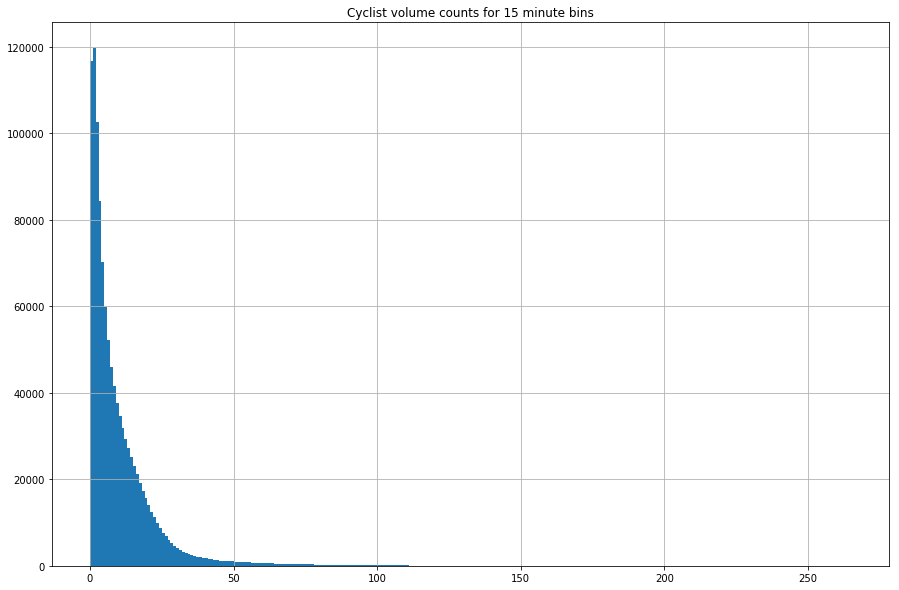

In [7]:
bin_val = np.arange(min(bikes['volume_15min']), max(bikes['volume_15min']), 1)

bikes.hist(bins=bin_val, figsize=(15,10))
plt.title('Cyclist volume counts for 15 minute bins')
plt.rc('font', size=10)          
plt.rc('axes', titlesize=15)


None of the Cyclist counts seem to be extreme values. It is quite normal to assume that there would be a high number of 0 or low count values, since cycling is not as popular of a form of transportation duing certain seasons, weather conditions, or times of days. 


## Unsuccessful attempts at finding extreme values 

First, I will try the same approach that was used with the ATR short term dataset. The code I used to create the exceptions table: 
```sql 
DROP MATERIALIZED VIEW IF EXISTS open_data.volumes_atr_permanent_exceptions;
CREATE MATERIALIZED VIEW  open_data.volumes_atr_permanent_exceptions AS 
(
-- get day/locations where there exists a value of 0 and a value above 20 within an hour of each other. 
-- Also get days that have a volume of under 450 and a volume of over 1000 wihtin an hour of each other
SELECT o1.datetime_bin::date, o1.location 
FROM open_data.volumes_atr_permanent o1 JOIN open_data.volumes_atr_permanent o2 ON o1.location = o2.location  
WHERE (CASE WHEN (o1.datetime_bin - o2.datetime_bin) < interval '0' THEN (-(o1.datetime_bin - o2.datetime_bin)) ELSE (o1.datetime_bin - o2.datetime_bin) END) <= interval '1 hour' 
AND ((o1.volume_15min > 20 AND o2.volume_15min = 0) OR (o1.volume_15min < 450 AND o2.volume_15min > 1000) ) 

UNION 

(SELECT o2.datetime_bin::date, o2.location FROM open_data.volumes_atr_permanent o1 JOIN open_data.volumes_atr_permanent o2 ON o1.location = o2.location 
WHERE (CASE WHEN (o1.datetime_bin - o2.datetime_bin) < interval '0' THEN (-(o1.datetime_bin - o2.datetime_bin)) ELSE (o1.datetime_bin - o2.datetime_bin) END) <= interval '1 hour' AND 
((o1.volume_15min > 20 AND o2.volume_15min = 0) OR (o1.volume_15min < 450 AND o2.volume_15min > 1000))  )


UNION 
-- get days that only have less than 3 records for a location+date and a max value that is strangley high or a mininum value for that location+date that is extremely low
(
SELECT datetime_bin::DATE, location
FROM open_data.volumes_atr_permanent v
GROUP BY datetime_bin::DATE, location
-- CHANGE MAX TO OVER 1000 ??? WOULD HELP IN BURNHAMTHORPE AND RENFORTH THING and etobicoke creek/bloor 
HAVING (COUNT(*) <= 3 AND (MAX(volume_15min) > 1000 OR MIN(volume_15min) <= 5)) OR AVG(volume_15min) = 0
)

);

```
This ran for over 18 hours before the execution was terminated ... it took way too long. 


The next try was an approach that got rid of the double joining. I made a view of every hour-location combination and got the average, median, max, min, count for each combination for weekdays, weekends and holidays. Then I made a second view which got the distinct dates that have a record that has a value of 0 and a hourly median of over 20, and the dates where there are volumes that are 3 times the hourly median (which I know is a condition that is way too arbitrary and was going to change later).

```sql 
DROP MATERIALIZED VIEW IF EXISTS open_data.volumes_atr_permanent_hour_location_avg;
-- Get the min, max, median, avg of each location-hour combination for weekdays, holidays and weekends
CREATE MATERIALIZED VIEW open_data.volumes_atr_permanent_hour_location_avg AS (
SELECT weekend.location AS location, weekend.hour AS hour, avg_weekday, max_weekday, min_weekday, median_weekday, count_weekday, 
avg_weekend, max_weekend,  min_weekend, median_weekend, count_weekend, 
 avg_holiday, max_holiday, min_holiday, median_holiday,count_holiday

FROM 

(
	SELECT location, date_part('hour', datetime_bin) AS hour, AVG(volume_15min) avg_weekday, MAX(volume_15min) max_weekday, MIN(volume_15min) min_weekday, 
	ROUND(PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY volume_15min)::numeric, 2) AS median_weekday, COUNT(*) AS count_weekday
	FROM open_data.volumes_atr_permanent
	WHERE date_part('dow', datetime_bin) in (1,2,3,4,5)
	AND datetime_bin::DATE NOT IN (SELECT dt FROM ref.holiday)
	GROUP BY location, date_part('hour', datetime_bin)
	
) AS weekday 

JOIN 


(
	SELECT location, date_part('hour', datetime_bin) AS hour, AVG(volume_15min) avg_weekend, MAX(volume_15min) max_weekend, MIN(volume_15min) min_weekend, 
	ROUND(PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY volume_15min)::numeric, 2) AS median_weekend, COUNT(*) AS count_weekend
	FROM open_data.volumes_atr_permanent
	WHERE date_part('dow', datetime_bin) in (0, 6)
	AND datetime_bin::DATE NOT IN (SELECT dt FROM ref.holiday)
	GROUP BY location, date_part('hour', datetime_bin)
	


) AS weekend

ON weekday.location = weekend.location AND weekday.hour = weekend.hour

JOIN

(

	SELECT location, date_part('hour', datetime_bin) AS hour, AVG(volume_15min) avg_holiday, MAX(volume_15min) max_holiday, MIN(volume_15min) min_holiday, 
	ROUND(PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY volume_15min)::numeric, 2) AS median_holiday, COUNT(*) AS count_holiday
	FROM open_data.volumes_atr_permanent
	WHERE datetime_bin::DATE IN (SELECT dt FROM ref.holiday)
	GROUP BY location, date_part('hour', datetime_bin)
	

) AS holiday 

ON  weekend.location = holiday.location  AND weekend.hour = holiday.hour
);


-- get the values that are off from avgs/appropriate mins/max's

CREATE MATERIALIZED VIEW open_data.volumes_atr_permanent_exceptions AS (

SELECT DISTINCT location, datetime_bin::DATE 
FROM open_data.volumes_atr_permanent o
WHERE 

 -- a value of zero and a median hour/location/(weekend holiday weekday) combination with a value above 20
	(
	volume_15min = 0 
	AND   (
		SELECT CASE 
		WHEN datetime_bin::DATE IN (SELECT dt FROM ref.holiday) THEN median_holiday
		WHEN date_part('dow', o.datetime_bin) IN (0,1,2,3,4,5) THEN median_weekday
		ELSE median_weekend
		END 
		FROM open_data.volumes_atr_permanent_hour_location_avg AS i
		WHERE o.location = i.location AND date_part('hour', o.datetime_bin) = i.hour
		) > 20
	)

OR 

-- when value more than 3 times the median value for that hour-location combination  
	(
	volume_15min > 3*(
		SELECT CASE 
		WHEN datetime_bin::DATE IN (SELECT dt FROM ref.holiday) THEN median_holiday
		WHEN date_part('dow', o.datetime_bin) IN (0,1,2,3,4,5) THEN median_weekday
		ELSE median_weekend
		END 
		FROM open_data.volumes_atr_permanent_hour_location_avg AS i
		WHERE o.location = i.location AND date_part('hour', o.datetime_bin) = i.hour
		)


	)

);

```

This was left to run over night and ran for about 11 hours. 

I decided to check the approach by running some basic QA/QC . 


Not all of the records with values over 2000 are in the exceptions table, which is already wrong.  
```sql 
-- 1155/2575 records with values over 2000 are in the exceptions table (i.e. their date/location combos are in the exceptions table)
SELECT

(SELECT COUNT(*) 
FROM open_data.volumes_atr_permanent o 
WHERE EXISTS 
(SELECT * FROM open_data.volumes_atr_permanent_exceptions WHERE o.datetime_bin::DATE = datetime_bin AND o.location = location) AND volume_15min > 2000) in_exceptions,

(SELECT COUNT(*) FROM open_data.volumes_atr_permanent WHERE volume_15min > 2000) all_over_2000;



-- almost all of the volumes over 1000 are in the exceptions table 
-- 649 444 / 4 699 907
SELECT

(SELECT COUNT(*) 
FROM open_data.volumes_atr_permanent o 
WHERE EXISTS 
(SELECT * FROM open_data.volumes_atr_permanent_exceptions WHERE o.datetime_bin::DATE = datetime_bin AND o.location = location) AND volume_15min > 1000) 
in_exceptions,

(SELECT COUNT(*) FROM open_data.volumes_atr_permanent WHERE volume_15min > 1000) all_over_1000;
```

I decided to try and refine my process with a small portion of the original dataset before testing it on the entire dataset in order to save time. I first tried by selecting a million records from the `open_data.volumes_atr_permanent` view. 
```sql 
DROP MATERIALIZED VIEW open_data.volumes_atr_permanent_exceptions_subset;
CREATE MATERIALIZED VIEW open_data.volumes_atr_permanent_exceptions_subset AS (

SELECT DISTINCT location, datetime_bin::DATE 
FROM (SELECT * FROM open_data.volumes_atr_permanent LIMIT 1000000) o
WHERE 
	(
	volume_15min = 0 
	AND   (
		SELECT CASE 
		WHEN datetime_bin::DATE IN (SELECT dt FROM ref.holiday) THEN median_holiday
		WHEN date_part('dow', o.datetime_bin) IN (0,1,2,3,4,5) THEN median_weekday
		ELSE median_weekend
		END 
		FROM open_data.volumes_atr_permanent_hour_location_avg AS i
		WHERE o.location = i.location AND date_part('hour', o.datetime_bin) = i.hour
		) > 20
	)

OR 

-- when value more than 3 times the median value for that hour-location combination  
	(
	volume_15min > 5*(
		SELECT CASE 
		WHEN datetime_bin::DATE IN (SELECT dt FROM ref.holiday) THEN median_holiday
		WHEN date_part('dow', o.datetime_bin) IN (0,1,2,3,4,5) THEN median_weekday
		ELSE median_weekend
		END 
		FROM open_data.volumes_atr_permanent_hour_location_avg AS i
		WHERE o.location = i.location AND date_part('hour', o.datetime_bin) = i.hour
		)


	)

);
```


This ran quickly, but I realized that a lot of the extreme values may not be included in this query and there was no real way of figuring out how many extreme values were actually in the 1 million records selected. I made a subset of the `open_data.volumes_atr_permanent` dataset by taking all the records that occur on days with at least one volume of over 2000, and an additional 1 million records. 

```sql 
-- create sample dataset with all days worth of data with volume > 2000 + 1 mill other records
DROP MATERIALIZED VIEW IF EXISTS open_data.volumes_atr_permanent_subset;
CREATE MATERIALIZED VIEW open_data.volumes_atr_permanent_subset AS (
SELECT * 
FROM 
(
	SELECT * 
	FROM open_data.volumes_atr_permanent o
	WHERE EXISTS (SELECT * FROM open_data.volumes_atr_permanent WHERE o.location = location AND o.datetime_bin::DATE = datetime_bin::DATE AND volume_15min > 2000)
)  AS x 
UNION
(
	SELECT * 
	FROM open_data.volumes_atr_permanent o2
	LIMIT 1000000
	)

);
```

I decided to try a different approach other than using the min, max, avg and median values of the location per hour (weekday, weekend, holiday). I grouped each hour, day and location and made the same calculations for each group. 

```sql 
-- try by making a table with each hour, each day, each location averages
DROP MATERIALIZED VIEW IF EXISTS open_data.volumes_atr_permanent_day_hour_location;
CREATE MATERIALIZED VIEW open_data.volumes_atr_permanent_day_hour_location AS (
SELECT datetime_bin::DATE AS day, date_part('hour', datetime_bin) AS hour, location, MAX(volume_15min) as max, MIN(volume_15min) as min, AVG(volume_15min) as avg, ROUND(PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY volume_15min)::numeric, 2) AS median
FROM 
open_data.volumes_atr_permanent
GROUP BY day, hour, location 
);
```

I explored the dataset by looking at the data for a few locations/dates that were outputted by: 
```sql 

SELECT DISTINCT datetime_bin::DATE, date_part('hour', datetime_bin) AS hour, location 
FROM open_data.volumes_atr_permanent_subset
WHERE volume_15min = 0
GROUP BY datetime_bin::DATE, date_part('hour', datetime_bin), location 
HAVING COUNT(*) > 2;
```

I looked at patterns for some of the extreme values and thought about patterns I saw in the `open_data.volumes_atr_shortterm` dataset. I realized that the approach of grouping by weekday/weekend/holiday hours alone may not be the best way to tell extreme values since outliers that are not necessarily extreme could potentially be confused with each other. For example, if there is a highway closure a street may be more busy on a certain day for a couple of hours in comparison to other days at the same time. We would not want these values to be classified as extreme. However, these averages/values could still be useful when being used with other criteria to define extreme values. 

I then tried a similar approach to classifiying outliers as I did for the `open_data.volumes_atr_shortterm` dataset. However, this query took over 20 minutes (on the subset dataset) and I ended the execution. 

The query takes locations and dates where there is a value of 0 and a value of 20 during the same hour, and when there is value of 1000 and a value under 450 in the same hour. 
```sql 

DROP MATERIALIZED VIEW open_data.volumes_atr_permanent_exceptions_subset;
CREATE MATERIALIZED VIEW open_data.volumes_atr_permanent_exceptions_subset AS (

SELECT DISTINCT location, datetime_bin::DATE 
FROM (SELECT * FROM open_data.volumes_atr_permanent_subset) o
WHERE 
	(
	volume_15min = 0 
	AND (
		SELECT max 
		FROM open_data.volumes_atr_permanent_day_hour_location 
		WHERE location = o.location AND day = o.datetime_bin::DATE AND hour = date_part('hour', o.datetime_bin)
		) > 20
	)

OR 

-- when value more than 3 times the median value for that hour-location combination  
	(
	volume_15min > 1000 AND (
		SELECT min 
		FROM open_data.volumes_atr_permanent_day_hour_location 
		WHERE location = o.location AND day = o.datetime_bin::DATE AND hour = date_part('hour', o.datetime_bin)
		) < 450


	)

);
```

## Finding extreme values (First Try)

I used the view `open_data.volumes_atr_permanent_day_hour_location` which contained a max, min, and median value calculated for each recorded day at each hour at each location. 
```sql 
DROP MATERIALIZED VIEW IF EXISTS open_data.volumes_atr_permanent_day_hour_location;
CREATE MATERIALIZED VIEW open_data.volumes_atr_permanent_day_hour_location AS (
SELECT datetime_bin::DATE AS day, date_part('hour', datetime_bin) AS hour, location, class_type, 
MAX(volume_15min) as max, MIN(volume_15min) as min, AVG(volume_15min) as avg, 
ROUND(PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY volume_15min)::numeric, 2) AS median
FROM open_data.volumes_atr_permanent
GROUP BY day, hour, location, class_type
);

```

I found hours that had extreme values and selected their days into an exceptions table. My criteria for an extreme value was an hour with all the same volumes, or an hour with a maximum volume that is 4 times the median volume, and has a maximum volume greater than 1000. This criteria made sense to me because if a volume is really high in comparison to the rest of the volumes collected at that location in that hour, then the volume is incorrect. If there is a gradual increase in volumes to get to maximum volume and/or a decrease after a volume of over 1000 to a smaller volume, then the median for that hour will not be extremely low. So the maximum volume will be less than 4 times the median. Also, if an hour has the exact the same volumes for the whole hour, then the volumes collected in that hour are very sketchy and must be incorrect because it would be extremely unlikely to collect four 15-minute volume counts in a row that have the exact same volumes of vehicles. There are no bike volumes in the exceptions table since the bike volumes did not seem extreme (analysis was at the beginning of the ATR permanent section). 

```sql 
DROP VIEW IF EXISTS open_data.volumes_atr_permanent_exceptions;
CREATE VIEW open_data.volumes_atr_permanent_exceptions AS (
SELECT DISTINCT day
FROM open_data.volumes_atr_permanent_day_hour_location
WHERE 
(class_type = 'Vehicles' AND ((max > 4*median AND max > 1000) OR (max = min) OR (max > 10*min AND max > 1000))
);
```

** After some basic QA/QC was completed, the final query to create the exceptions table was edited to be this: **
```sql 
DROP VIEW IF EXISTS open_data.volumes_atr_permanent_exceptions;
CREATE VIEW open_data.volumes_atr_permanent_exceptions AS (
SELECT DISTINCT day, location, class_type
FROM open_data.volumes_atr_permanent_day_hour_location
WHERE
( class_type = 'Vehicles' AND ((max > 4*median AND max > 1000) OR (max = min) OR (max > 10*min AND max > 1000)) )

);
```

The extra criterion of adding days+locations where the hourly maximum is 10 times the size of the hourly minimum volume count and where the maximum is higher than 1000 was added. This criterion is neccessary because there are cases where there are two (potentially 3) extremely high values over the course of the hour, in comparison to the rest of the volumes around that time which are a lot lower. 


## QA/QC 

After formulating this way of identifying extreme values, the approach needed to be verified. To verify this approach, I looked at the number of volumes over 2000 that occured on dates in the exceptions table. Most days where volumes over 2000 were removed. 

In [8]:
sql = '''
SELECT COUNT(*)
FROM open_data.volumes_atr_permanent p
WHERE 
NOT EXISTS (SELECT * FROM open_data.volumes_atr_permanent_exceptions WHERE day = p.datetime_bin::DATE AND location = p.location)
AND volume_15min > 2000;
'''
pandasql.read_sql(sql, con)

,count
0,2321


In [9]:
# investigate these days and times
# I investigated them in pgAdmin so I could view them all 
# These records were only at a few (4) locations 
# mainly highways and/or rush hour times 
sql = '''
SELECT *
FROM open_data.volumes_atr_permanent p
WHERE 
NOT EXISTS (SELECT * FROM open_data.volumes_atr_permanent_exceptions WHERE day = p.datetime_bin::DATE AND location = p.location)
AND volume_15min > 2000;
'''
pandasql.read_sql(sql, con)

,centreline_id,direction,location,class_type,datetime_bin,volume_15min
0,1147010.0,Eastbound,F G GARDINER EXPY E/B W OF REES ST,Vehicles,1995-05-03 16:45:00,2048.0
1,1147010.0,Eastbound,F G GARDINER EXPY E/B W OF REES ST,Vehicles,1995-05-03 17:15:00,2148.0
2,1147010.0,Eastbound,F G GARDINER EXPY E/B W OF REES ST,Vehicles,1995-05-04 17:30:00,2021.0
3,1147010.0,Eastbound,F G GARDINER EXPY E/B W OF REES ST,Vehicles,1995-05-04 17:45:00,2072.0
4,1147010.0,Eastbound,F G GARDINER EXPY E/B W OF REES ST,Vehicles,1995-05-05 06:45:00,2060.0
5,1147010.0,Eastbound,F G GARDINER EXPY E/B W OF REES ST,Vehicles,1995-05-05 17:00:00,2037.0
6,1147010.0,Eastbound,F G GARDINER EXPY E/B W OF REES ST,Vehicles,1995-05-05 17:15:00,2095.0
7,1147010.0,Eastbound,F G GARDINER EXPY E/B W OF REES ST,Vehicles,1995-05-05 17:30:00,2002.0
8,1147010.0,Eastbound,F G GARDINER EXPY E/B W OF REES ST,Vehicles,1995-05-08 17:00:00,2061.0
9,1147010.0,Eastbound,F G GARDINER EXPY E/B W OF REES ST,Vehicles,1995-05-08 17:30:00,2072.0


In [10]:
# look at highest value not in exceptions table
sql = '''
SELECT MAX(volume_15min)
FROM  open_data.volumes_atr_permanent p
WHERE
NOT EXISTS (SELECT * FROM open_data.volumes_atr_permanent_exceptions WHERE day = p.datetime_bin::DATE AND location = p.location)
AND volume_15min > 1000
'''

pandasql.read_sql(sql, con)

,max
0,2712.0


In [11]:
# look at the day+location that highest value that's not in the exception table occurs on 
# you can see the gradual increase and decrease in volumes. The volumes stay high for most of the day. 
# This location also appears a lot in the query executed two above this one.
# so the high value is justified 
sql = '''
SELECT * 
FROM open_data.volumes_atr_permanent
WHERE datetime_bin::DATE = (SELECT datetime_bin::DATE FROM open_data.volumes_atr_permanent WHERE volume_15min = 2401)
AND location = (SELECT location FROM open_data.volumes_atr_permanent WHERE volume_15min = 2401)
'''

pandasql.read_sql(sql, con)

,centreline_id,direction,location,class_type,datetime_bin,volume_15min
0,9313402,Southbound,BATHURST ST S/B N OF FINCH AVE,Vehicles,2014-09-11 00:00:00,423.0
1,9313402,Southbound,BATHURST ST S/B N OF FINCH AVE,Vehicles,2014-09-11 00:15:00,427.0
2,9313402,Southbound,BATHURST ST S/B N OF FINCH AVE,Vehicles,2014-09-11 00:30:00,374.0
3,9313402,Southbound,BATHURST ST S/B N OF FINCH AVE,Vehicles,2014-09-11 00:45:00,318.0
4,9313402,Southbound,BATHURST ST S/B N OF FINCH AVE,Vehicles,2014-09-11 01:00:00,206.0
5,9313402,Southbound,BATHURST ST S/B N OF FINCH AVE,Vehicles,2014-09-11 01:15:00,218.0
6,9313402,Southbound,BATHURST ST S/B N OF FINCH AVE,Vehicles,2014-09-11 01:30:00,175.0
7,9313402,Southbound,BATHURST ST S/B N OF FINCH AVE,Vehicles,2014-09-11 01:45:00,123.0
8,9313402,Southbound,BATHURST ST S/B N OF FINCH AVE,Vehicles,2014-09-11 02:00:00,83.0
9,9313402,Southbound,BATHURST ST S/B N OF FINCH AVE,Vehicles,2014-09-11 02:15:00,112.0


I also investigated some of the days that had some volumes of 0. The volumes of 0 seemed to occur mainly in the early hours of the morning, and the ones I checked weren't concerning. 

```sql 
SELECT * FROM  open_data.volumes_atr_permanent p
WHERE NOT EXISTS (SELECT * FROM open_data.volumes_atr_permanent_exceptions WHERE day = p.datetime_bin::DATE AND location = p.location)
AND volume_15min = 0 
ORDER BY location, datetime_bin
```

## Final Code for view 

```sql 

CREATE MATERIALIZED VIEW open_data.volumes_atr_permanent_day_hour_location AS 
 SELECT volumes_atr_permanent.datetime_bin::date AS day,
    date_part('hour'::text, volumes_atr_permanent.datetime_bin) AS hour,
    volumes_atr_permanent.location,
    volumes_atr_permanent.class_type,
    max(volumes_atr_permanent.volume_15min) AS max,
    min(volumes_atr_permanent.volume_15min) AS min,
    avg(volumes_atr_permanent.volume_15min) AS avg,
    round(percentile_cont(0.50::double precision) WITHIN GROUP (ORDER BY (volumes_atr_permanent.volume_15min::double precision))::numeric, 2) AS median
   FROM (SELECT DISTINCT flow.centreline_id,
    flow.direction,
    flow.location,
    flow.class_type,
    flow.datetime_bin,
    flow.volume_15min
   FROM ( SELECT flow_atr.centreline_id,
            flow_atr.direction,
            flow_atr.location,
            flow_atr.class_type,
            flow_atr.datetime_bin,
            flow_atr.volume_15min
           FROM open_data.flow_atr
          WHERE flow_atr.station_type = 'Permanent'::text AND flow_atr.volume_15min >= 0::numeric
           ) flow
UNION ALL
 SELECT a.centreline_id,
    a.direction,
    a.location_desc AS location,
    'Cyclists'::text AS class_type,
    b.datetime_bin,
    b.volume_15min
   FROM ecocounter.sites a
     JOIN ecocounter.volumes b USING (site_id)
  WHERE b.volume_15min >= 0
  ORDER BY 1, 5, 2) AS volumes_atr_permanent
  GROUP BY (volumes_atr_permanent.datetime_bin::date), (date_part('hour'::text, volumes_atr_permanent.datetime_bin)), volumes_atr_permanent.location, volumes_atr_permanent.class_type
WITH DATA;




CREATE OR REPLACE VIEW open_data.volumes_atr_permanent_exceptions AS 
 SELECT DISTINCT volumes_atr_permanent_day_hour_location.day,
    volumes_atr_permanent_day_hour_location.location,
    volumes_atr_permanent_day_hour_location.class_type
   FROM open_data.volumes_atr_permanent_day_hour_location
  WHERE volumes_atr_permanent_day_hour_location.class_type = 'Vehicles'::text AND (volumes_atr_permanent_day_hour_location.max > (4::numeric * volumes_atr_permanent_day_hour_location.median) AND volumes_atr_permanent_day_hour_location.max > 1000::numeric OR volumes_atr_permanent_day_hour_location.max = volumes_atr_permanent_day_hour_location.min OR volumes_atr_permanent_day_hour_location.max > (10::numeric * volumes_atr_permanent_day_hour_location.min) AND volumes_atr_permanent_day_hour_location.max > 1000::numeric);


DROP MATERIALIZED VIEW open_data.volumes_atr_permanent;
CREATE MATERIALIZED VIEW open_data.volumes_atr_permanent AS 
 SELECT DISTINCT flow.centreline_id,
    flow.direction,
    flow.location,
    flow.class_type,
    flow.datetime_bin,
    flow.volume_15min
   FROM ( SELECT flow_atr.centreline_id,
            flow_atr.direction,
            flow_atr.location,
            flow_atr.class_type,
            flow_atr.datetime_bin,
            flow_atr.volume_15min
           FROM open_data.flow_atr 
          WHERE flow_atr.station_type = 'Permanent'::text AND flow_atr.volume_15min >= 0::numeric
          AND NOT EXISTS (SELECT * FROM open_data.volumes_atr_permanent_exceptions WHERE flow_atr.location = location AND flow_atr.datetime_bin::DATE = day) ) flow
UNION ALL
 SELECT a.centreline_id,
    a.direction,
    a.location_desc AS location,
    'Cyclists'::text AS class_type,
    b.datetime_bin,
    b.volume_15min
   FROM ecocounter.sites a
     JOIN ecocounter.volumes b USING (site_id)
  WHERE b.volume_15min >= 0
  ORDER BY 1, 5, 2
WITH DATA;


```

# Adopting Methods From the ATR Bikes Extreme Value Analysis

Look at every hour of a month and find outliers (i.e. average every June bin between 4 PM and 5PM and use the IQR method to find outliers/extreme values). I will use a modified IQR method, instead of using the 75th and 25th percentiles, I will use the 95th and 5th percentiles. 

### Try for one location 

In [2]:
sql_volumes = '''
SELECT centreline_id, 
direction, location, class_type, datetime_bin, volume_15min, date_part('hour', datetime_bin) AS hour, 
date_part('month', datetime_bin) AS month
FROM open_data.volumes_atr_permanent
WHERE direction = 'Eastbound' AND centreline_id = 1147026
'''

volumes = pandasql.read_sql(sql_volumes, con)

# "LAKE SHORE BLVD E/B W OF REES ST"
sql_locations = '''
SELECT DISTINCT ON (centreline_id, direction) centreline_id, direction
FROM open_data.volumes_atr_permanent
WHERE direction = 'Eastbound' AND centreline_id = 1147026
'''

locations = pandasql.read_sql(sql_locations, con)

In [15]:
outliers = pd.DataFrame(
    columns=['centreline_id', 'direction', 'location', 'class_type', 'datetime_bin', 'volume_15min'])


volumes_weekday = volumes.loc[(volumes['datetime_bin'].dt.weekday.isin([1,2,3,4,5]))]

volumes_weekend =  volumes.loc[(volumes['datetime_bin'].dt.weekday.isin([0, 6]))]


# we = weekend, wd = weekday

for row in locations.itertuples():
    for month in range(1, 12):
        for hr in range(0, 23):
            
            # get the subsets
            subset_weekday = volumes_weekday.loc[(volumes_weekday['hour'] == hr) & (volumes_weekday['month'] == month) 
                                                 & (volumes_weekday['centreline_id'] == row[1]) 
                                                 & (volumes_weekday['direction'] == row[2])
                                                ]
            subset_weekend = volumes_weekend.loc[(volumes_weekend['hour'] == hr) & (volumes_weekend['month'] == month)
                                                 & (volumes_weekend['centreline_id'] == row[1]) 
                                                 & (volumes_weekend['direction'] == row[2])
                                                ]

                # weekday IQR
            p5_wd, p95_wd = np.percentile(subset_weekday['volume_15min'], 5), np.percentile(subset_weekday['volume_15min'], 95)
            iqr_wd = p95_wd - p5_wd

            # weekend IQR
            p5_we, p95_we = np.percentile(subset_weekend['volume_15min'], 5), np.percentile(subset_weekend['volume_15min'], 95)
            iqr_we = p95_we - p5_we

            
            # calculate outlier cut off 
            # if volume value is not between lower and upper than it will be considered an outlier
            cut_off_we = iqr_we*1.5
            
            cut_off_wd = iqr_wd*1.5

            
            lower_we, upper_we = int(p5_we - cut_off_we), int(p95_we + cut_off_we)
            
            lower_wd, upper_wd = int(p5_wd - cut_off_wd), int(p95_wd + cut_off_wd)
            
            # we cannot have a negative traffic volume
            if lower_we < 0: 
                lower_we = 0
                
            if lower_wd < 0: 
                lower_wd = 0

            frames = [outliers, 
                     subset_weekend.loc[(subset_weekend['volume_15min'] < lower_we) | 
                                         (subset_weekend['volume_15min'] > upper_we)  ], 
                      subset_weekday.loc[(subset_weekday['volume_15min'] < lower_wd) | 
                                         (subset_weekday['volume_15min'] > upper_wd)  ]
                     ]
            outliers = pd.concat(frames)

In [19]:
# there are 133 outliers for this location
len(outliers)

133

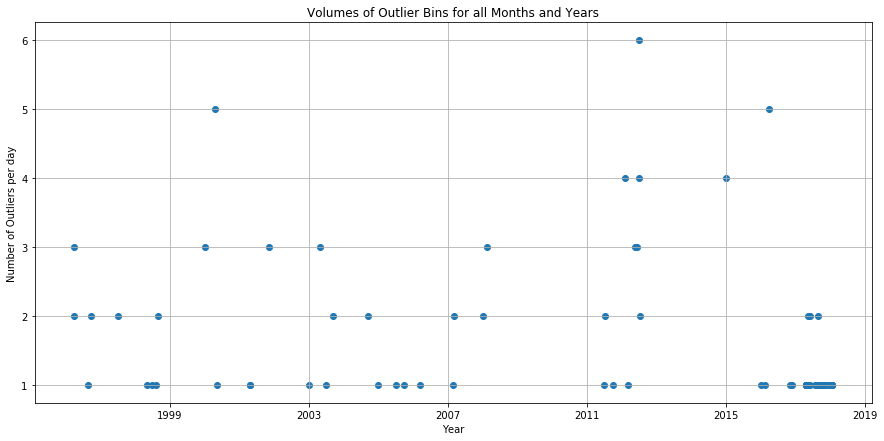

In [20]:
# look at when the outliers occurred and how many outliers occur in a day
fig, ax = plt.subplots(figsize=(15,7))
counts = outliers.groupby(outliers['datetime_bin'].dt.date).count()['centreline_id']
plt.scatter(counts.index, counts)

ax.set_xlabel("Year")
ax.set_ylabel("Number of Outliers per day")
plt.title("Volumes of Outlier Bins for all Months and Years")
ax.xaxis.grid()
ax.yaxis.grid()

Most of the time, there are very few outliers that occur in a day. There is only 1 day with more than 5 outliers.

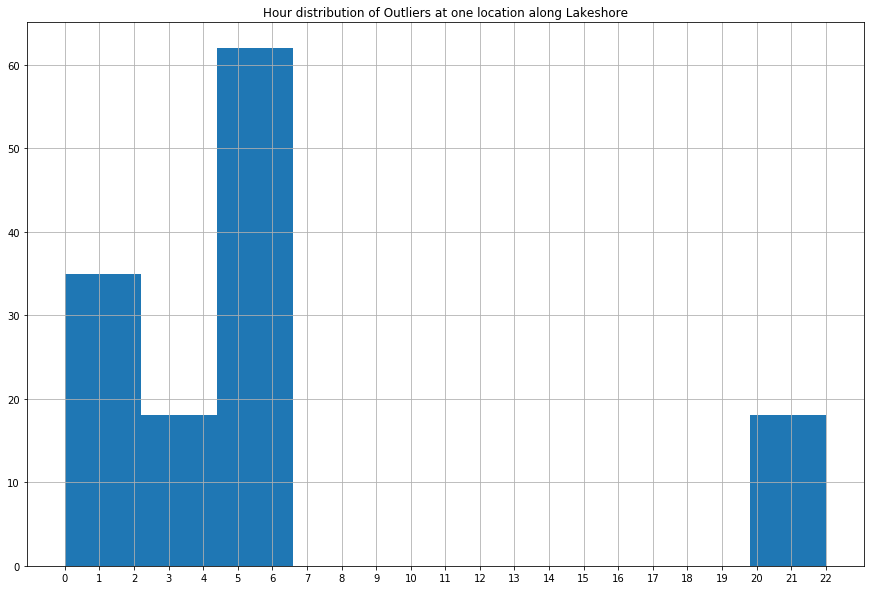

In [25]:
ax = outliers['hour'].hist(figsize=(15,10))
plt.xticks(np.arange(0, 23, 1))
plt.title("Hour distribution of Outliers at one location along Lakeshore")

In this case, most of the outliers occur during the very early hours of the morning or in the late hours of night. 

### Look at all locations

Running the same process on the entire ATR permanent data set using the same python code is not possible since the data set has over 65 million records.`Pandas` was not able to load the entire data set into a data frame in an appropriate amount of time. Also, loading the data set was freezing and slowing my computer down, so the only other option was to create an algorithm to identify outliers in Postgres. I chose to not use the three for loops because more than one for loop (or arguably any number of for loops) take an extremely long time to run on large data sets and should be avoided at all costs.  

My algorithm created a table with every combination of location, day and month by taking the cross product of a table with every month of the year, a table with every hour of the day, and a table with every location. I used a lateral join to get the outliers for each combination. For each combination, I calculated the upper (95th percentile + IQR$*$1.5) and lower (5th percentile - IQR$*$1.5) value and then joined the table with the upper and lower values to the original dataset and only included volume bins where the volume was greater than upper of less than lower. I did this calculation on both the weekend data and the weekday data and then unioned the identified outliers into one table, which was joined laterally to the location-month-day combination table.


```sql 
-- create tables to be merged into the location-month-daycombination table 
CREATE TABLE crosic.hours (
hr int
); 

INSERT INTO crosic.hours VALUES (0),(1),(2),(3),(4),(5),(6), (7), (8), (9), (10), (11), (12), (13),(14),(15),(16), (17), (18), (19), (20), (21), (22), (23)



CREATE TABLE crosic.months (
month int
); 

INSERT INTO crosic.months VALUES (1),(2),(3),(4),(5),(6),(7), (8), (9), (10), (11), (12)




DROP INDEX IF EXISTS open_data.atr_perm;
CREATE INDEX atr_perm ON open_data.volumes_atr_permanent (centreline_id, direction, class_type, date_part('month', datetime_bin), date_part('hour', datetime_bin));


DROP INDEX IF EXISTS open_data.atr_perm_weekday;
CREATE INDEX atr_perm_weekday ON open_data.volumes_atr_permanent (centreline_id, direction, class_type, date_part('month', datetime_bin), date_part('hour', datetime_bin), date_part('dow', datetime_bin)); 






DROP TABLE locations ;
CREATE TEMP TABLE locations AS (
SELECT DISTINCT ON (centreline_id, class_type, direction) centreline_id, direction, class_type
FROM open_data.volumes_atr_permanent
);




DROP TABLE IF EXISTS  crosic.atr_permanent_outliers;


EXPLAIN ANALYZE SELECT outliers.centreline_id, outliers.direction, outliers.class_type, datetime_bin
INTO crosic.atr_permanent_outliers
FROM 

-- get every combination of location + hour + month combination 
(SELECT * FROM locations CROSS JOIN crosic.hours CROSS JOIN crosic.months) location_month_hour_combos

LEFT JOIN LATERAL

(




( 
SELECT weekday.centreline_id, weekday.direction, weekday.class_type, datetime_bin
FROM  open_data.volumes_atr_permanent perm
INNER JOIN 
-- weekday
(
	SELECT centreline_id, direction, class_type, date_part('month', datetime_bin) AS month, date_part('hour', datetime_bin) AS hr,
	(((PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY volume_15min)) - (PERCENTILE_CONT(0.05) WITHIN GROUP (ORDER BY volume_15min)))*1.5 + (PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY volume_15min))) AS upper,
	
	( CASE WHEN ((PERCENTILE_CONT(0.05) WITHIN GROUP (ORDER BY volume_15min)) - ((PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY volume_15min)) - (PERCENTILE_CONT(0.05) WITHIN GROUP (ORDER BY volume_15min)))*1.5 ) < 0
	THEN 0 
	ELSE ((PERCENTILE_CONT(0.05) WITHIN GROUP (ORDER BY volume_15min)) - ((PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY volume_15min)) - (PERCENTILE_CONT(0.05) WITHIN GROUP (ORDER BY volume_15min)))*1.5 )
	END ) AS lower
	
	FROM open_data.volumes_atr_permanent volumes
	WHERE date_part('hour', datetime_bin) = location_month_hour_combos.hr
	AND date_part('month', datetime_bin) = location_month_hour_combos.month
	AND centreline_id = location_month_hour_combos.centreline_id 
	AND direction = location_month_hour_combos.direction 
	AND date_part('dow', datetime_bin) IN (1,2,3,4,5)
	AND class_type = location_month_hour_combos.class_type
	GROUP BY centreline_id, direction, class_type, date_part('month', datetime_bin), date_part('hour', datetime_bin)


) AS weekday
ON perm.centreline_id = weekday.centreline_id AND perm.direction = weekday.direction AND date_part('month', perm.datetime_bin) = weekday.month AND date_part('hour', perm.datetime_bin) = weekday.hr
WHERE volume_15min > upper OR volume_15min < lower
)


UNION 



( 
SELECT weekend.centreline_id, weekend.direction, weekend.class_type, datetime_bin
FROM 
 open_data.volumes_atr_permanent AS perm
INNER JOIN 
-- weekend
(
	SELECT centreline_id, direction, class_type, date_part('month', datetime_bin) AS month, date_part('hour', datetime_bin) AS hr,
	(((PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY volume_15min)) - (PERCENTILE_CONT(0.05) WITHIN GROUP (ORDER BY volume_15min)))*1.5 + (PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY volume_15min))) AS upper,
	
	( CASE WHEN ((PERCENTILE_CONT(0.05) WITHIN GROUP (ORDER BY volume_15min)) - ((PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY volume_15min)) - (PERCENTILE_CONT(0.05) WITHIN GROUP (ORDER BY volume_15min)))*1.5 ) < 0
	THEN 0 
	ELSE ((PERCENTILE_CONT(0.05) WITHIN GROUP (ORDER BY volume_15min)) - ((PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY volume_15min)) - (PERCENTILE_CONT(0.05) WITHIN GROUP (ORDER BY volume_15min)))*1.5 )
	END ) AS lower
	
	FROM  open_data.volumes_atr_permanent volumes
	WHERE date_part('hour', datetime_bin) = location_month_hour_combos.hr
	AND date_part('month', datetime_bin) = location_month_hour_combos.month
	AND centreline_id = location_month_hour_combos.centreline_id 
	AND direction = location_month_hour_combos.direction 
	AND date_part('dow', datetime_bin) IN (0, 6)
	GROUP BY centreline_id, direction, class_type, date_part('month', datetime_bin), date_part('hour', datetime_bin)


) AS weekend
ON perm.centreline_id = weekend.centreline_id AND perm.direction = weekend.direction AND date_part('month', perm.datetime_bin) = weekend.month AND date_part('hour', perm.datetime_bin) = weekend.hr
WHERE volume_15min > upper OR volume_15min < lower
)





) outliers
ON trueDROP INDEX IF EXISTS open_data.atr_perm;
CREATE INDEX atr_perm ON open_data.volumes_atr_permanent (centreline_id, direction, class_type, date_part('month', datetime_bin), date_part('hour', datetime_bin));


DROP INDEX IF EXISTS open_data.atr_perm_weekday;
CREATE INDEX atr_perm_weekday ON open_data.volumes_atr_permanent (centreline_id, direction, class_type, date_part('month', datetime_bin), date_part('hour', datetime_bin), date_part('dow', datetime_bin)); 






DROP TABLE IF EXISTS locations;
CREATE TEMP TABLE locations AS (
SELECT DISTINCT ON (centreline_id, class_type, direction) centreline_id, direction, class_type
FROM open_data.volumes_atr_permanent
);




DROP TABLE IF EXISTS  crosic.atr_permanent_outliers;


EXPLAIN ANALYZE SELECT outliers.centreline_id, outliers.direction, outliers.class_type, datetime_bin
INTO crosic.atr_permanent_outliers
FROM 

-- get every combination of location + hour + month combination 
(SELECT * FROM locations CROSS JOIN crosic.hours CROSS JOIN crosic.months) location_month_hour_combos

LEFT JOIN LATERAL

(




( 
SELECT weekday.centreline_id, weekday.direction, weekday.class_type, perm.datetime_bin
FROM  open_data.volumes_atr_permanent perm
INNER JOIN 
-- weekday
(
	SELECT centreline_id, direction, class_type, date_part('month', datetime_bin) AS month, date_part('hour', datetime_bin) AS hr,
	(((PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY volume_15min)) - (PERCENTILE_CONT(0.05) WITHIN GROUP (ORDER BY volume_15min)))*1.5 + (PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY volume_15min))) AS upper,
	
	( CASE WHEN ((PERCENTILE_CONT(0.05) WITHIN GROUP (ORDER BY volume_15min)) - ((PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY volume_15min)) - (PERCENTILE_CONT(0.05) WITHIN GROUP (ORDER BY volume_15min)))*1.5 ) < 0
	THEN 0 
	ELSE ((PERCENTILE_CONT(0.05) WITHIN GROUP (ORDER BY volume_15min)) - ((PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY volume_15min)) - (PERCENTILE_CONT(0.05) WITHIN GROUP (ORDER BY volume_15min)))*1.5 )
	END ) AS lower
	
	FROM open_data.volumes_atr_permanent volumes
	WHERE date_part('hour', datetime_bin) = location_month_hour_combos.hr
	AND date_part('month', datetime_bin) = location_month_hour_combos.month
	AND centreline_id = location_month_hour_combos.centreline_id 
	AND direction = location_month_hour_combos.direction 
	AND date_part('dow', datetime_bin) IN (1,2,3,4,5)
	AND class_type = location_month_hour_combos.class_type
	GROUP BY centreline_id, direction, class_type, date_part('month', datetime_bin), date_part('hour', datetime_bin)


) AS weekday
ON perm.centreline_id = weekday.centreline_id AND perm.direction = weekday.direction AND date_part('month', perm.datetime_bin) = weekday.month AND date_part('hour', perm.datetime_bin) = weekday.hr
WHERE (volume_15min > upper OR volume_15min < lower) AND date_part('dow', datetime_bin) IN (1,2,3,4,5)
)


UNION 



( 
SELECT weekend.centreline_id, weekend.direction, weekend.class_type, perm.datetime_bin
FROM 
 open_data.volumes_atr_permanent AS perm
INNER JOIN 
-- weekend
(
	SELECT centreline_id, direction, class_type, date_part('month', datetime_bin) AS month, date_part('hour', datetime_bin) AS hr,
	(((PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY volume_15min)) - (PERCENTILE_CONT(0.05) WITHIN GROUP (ORDER BY volume_15min)))*1.5 + (PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY volume_15min))) AS upper,
	
	( CASE WHEN ((PERCENTILE_CONT(0.05) WITHIN GROUP (ORDER BY volume_15min)) - ((PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY volume_15min)) - (PERCENTILE_CONT(0.05) WITHIN GROUP (ORDER BY volume_15min)))*1.5 ) < 0
	THEN 0 
	ELSE ((PERCENTILE_CONT(0.05) WITHIN GROUP (ORDER BY volume_15min)) - ((PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY volume_15min)) - (PERCENTILE_CONT(0.05) WITHIN GROUP (ORDER BY volume_15min)))*1.5 )
	END ) AS lower
	
	FROM  open_data.volumes_atr_permanent volumes
	WHERE date_part('hour', datetime_bin) = location_month_hour_combos.hr
	AND date_part('month', datetime_bin) = location_month_hour_combos.month
	AND centreline_id = location_month_hour_combos.centreline_id 
	AND direction = location_month_hour_combos.direction 
	AND date_part('dow', datetime_bin) IN (0, 6)
	GROUP BY centreline_id, direction, class_type, date_part('month', datetime_bin), date_part('hour', datetime_bin)


) AS weekend
ON perm.centreline_id = weekend.centreline_id AND perm.direction = weekend.direction AND date_part('month', perm.datetime_bin) = weekend.month AND date_part('hour', perm.datetime_bin) = weekend.hr
WHERE (volume_15min > upper OR volume_15min < lower) AND date_part('dow', datetime_bin) IN (0, 6)
)





) outliers
ON true
```


After the code ran, there were 143 828 records in the outliers table (68 427 of those records are not empty rows). Look into these records more and find out how many days have more than 5 outliers. 

In [3]:
sql = '''
SELECT * 
FROM crosic.atr_permanent_outliers
WHERE centreline_id IS NOT NULL
'''

outliers = pandasql.read_sql(sql, con)

In [4]:
outliers['date'] = outliers['datetime_bin'].dt.date

# create a column to tell if day is during the week or weekend
def weekday_type(df_col): 
    df_col = pd.DataFrame(df_col)
    weekday_type = []
    for i in range(0, len(df_col)):
        if (df_col[0][i]).dayofweek in [1,2,3,5]:
            weekday_type.append('weekday')
        else:
            weekday_type.append('weekend')
    return weekday_type

outliers['weekday_type'] =  weekday_type(outliers['datetime_bin'].values)

In [77]:
counts = outliers.groupby(['date', 'class_type', 'centreline_id', 'direction']).count()
    
dates = (counts.index).to_frame()['date']

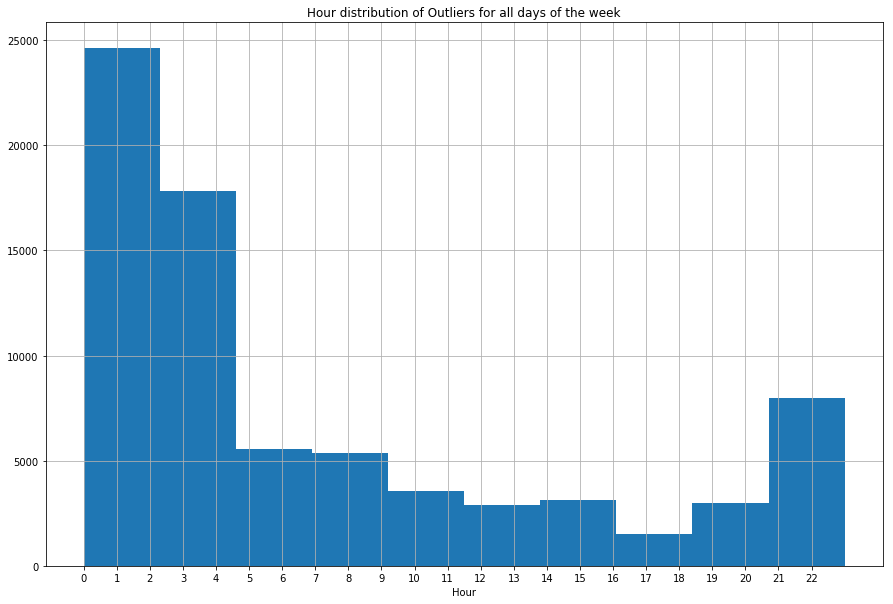

In [50]:
ax = outliers['datetime_bin'].dt.hour.hist(figsize=(15,10))
plt.xticks(np.arange(0, 23, 1))
plt.title("Hour distribution of Outliers for all days of the week")
ax.set_xlabel("Hour")

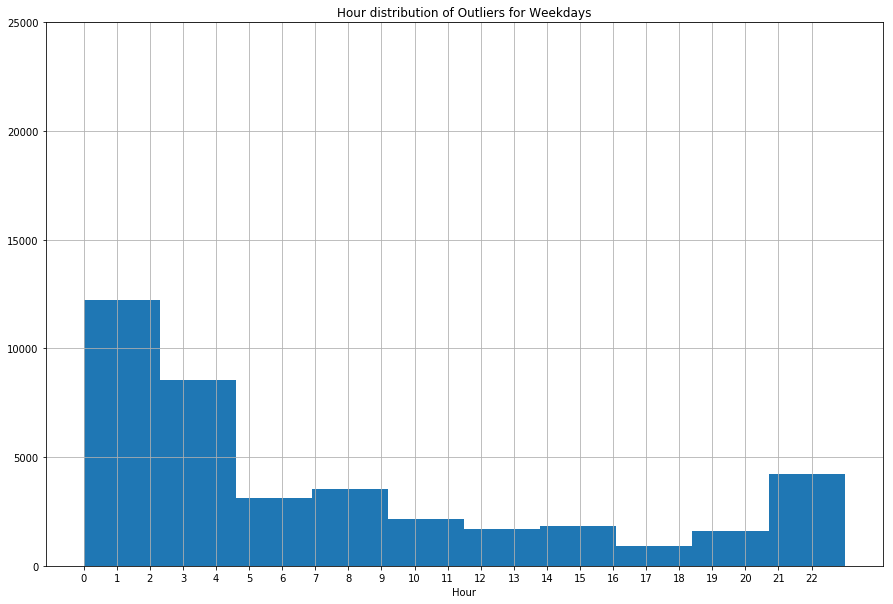

In [51]:
ax = (outliers['datetime_bin'].loc[outliers['weekday_type'] == 'weekday']).dt.hour.hist(figsize=(15,10))
plt.xticks(np.arange(0, 23, 1))
ax.set_ylim(0, 25000)
plt.title("Hour distribution of Outliers for Weekdays")
ax.set_xlabel("Hour")

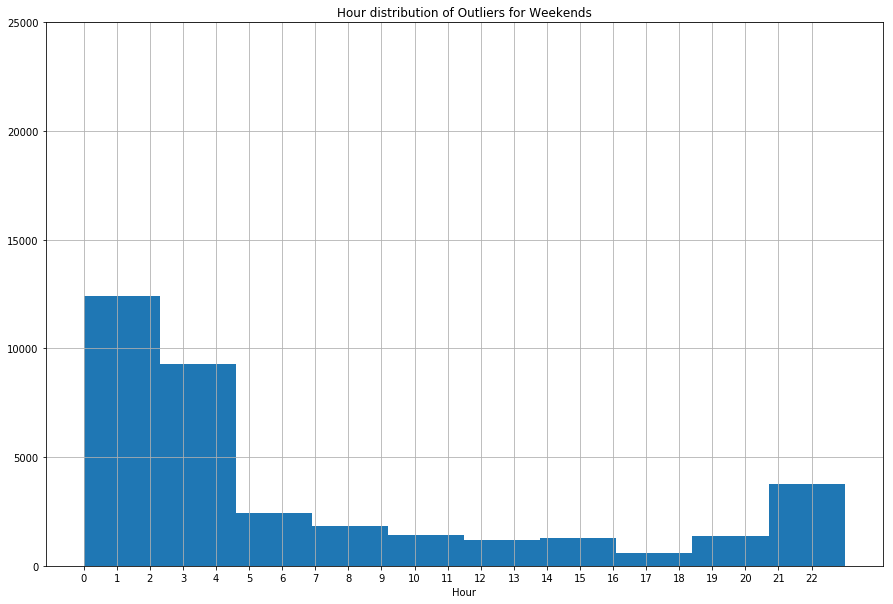

In [52]:
ax = (outliers['datetime_bin'].loc[outliers['weekday_type'] == 'weekend']).dt.hour.hist(figsize=(15,10))
ax.set_ylim(0, 25000)
plt.xticks(np.arange(0, 23, 1))
plt.title("Hour distribution of Outliers for Weekends")
ax.set_xlabel("Hour")

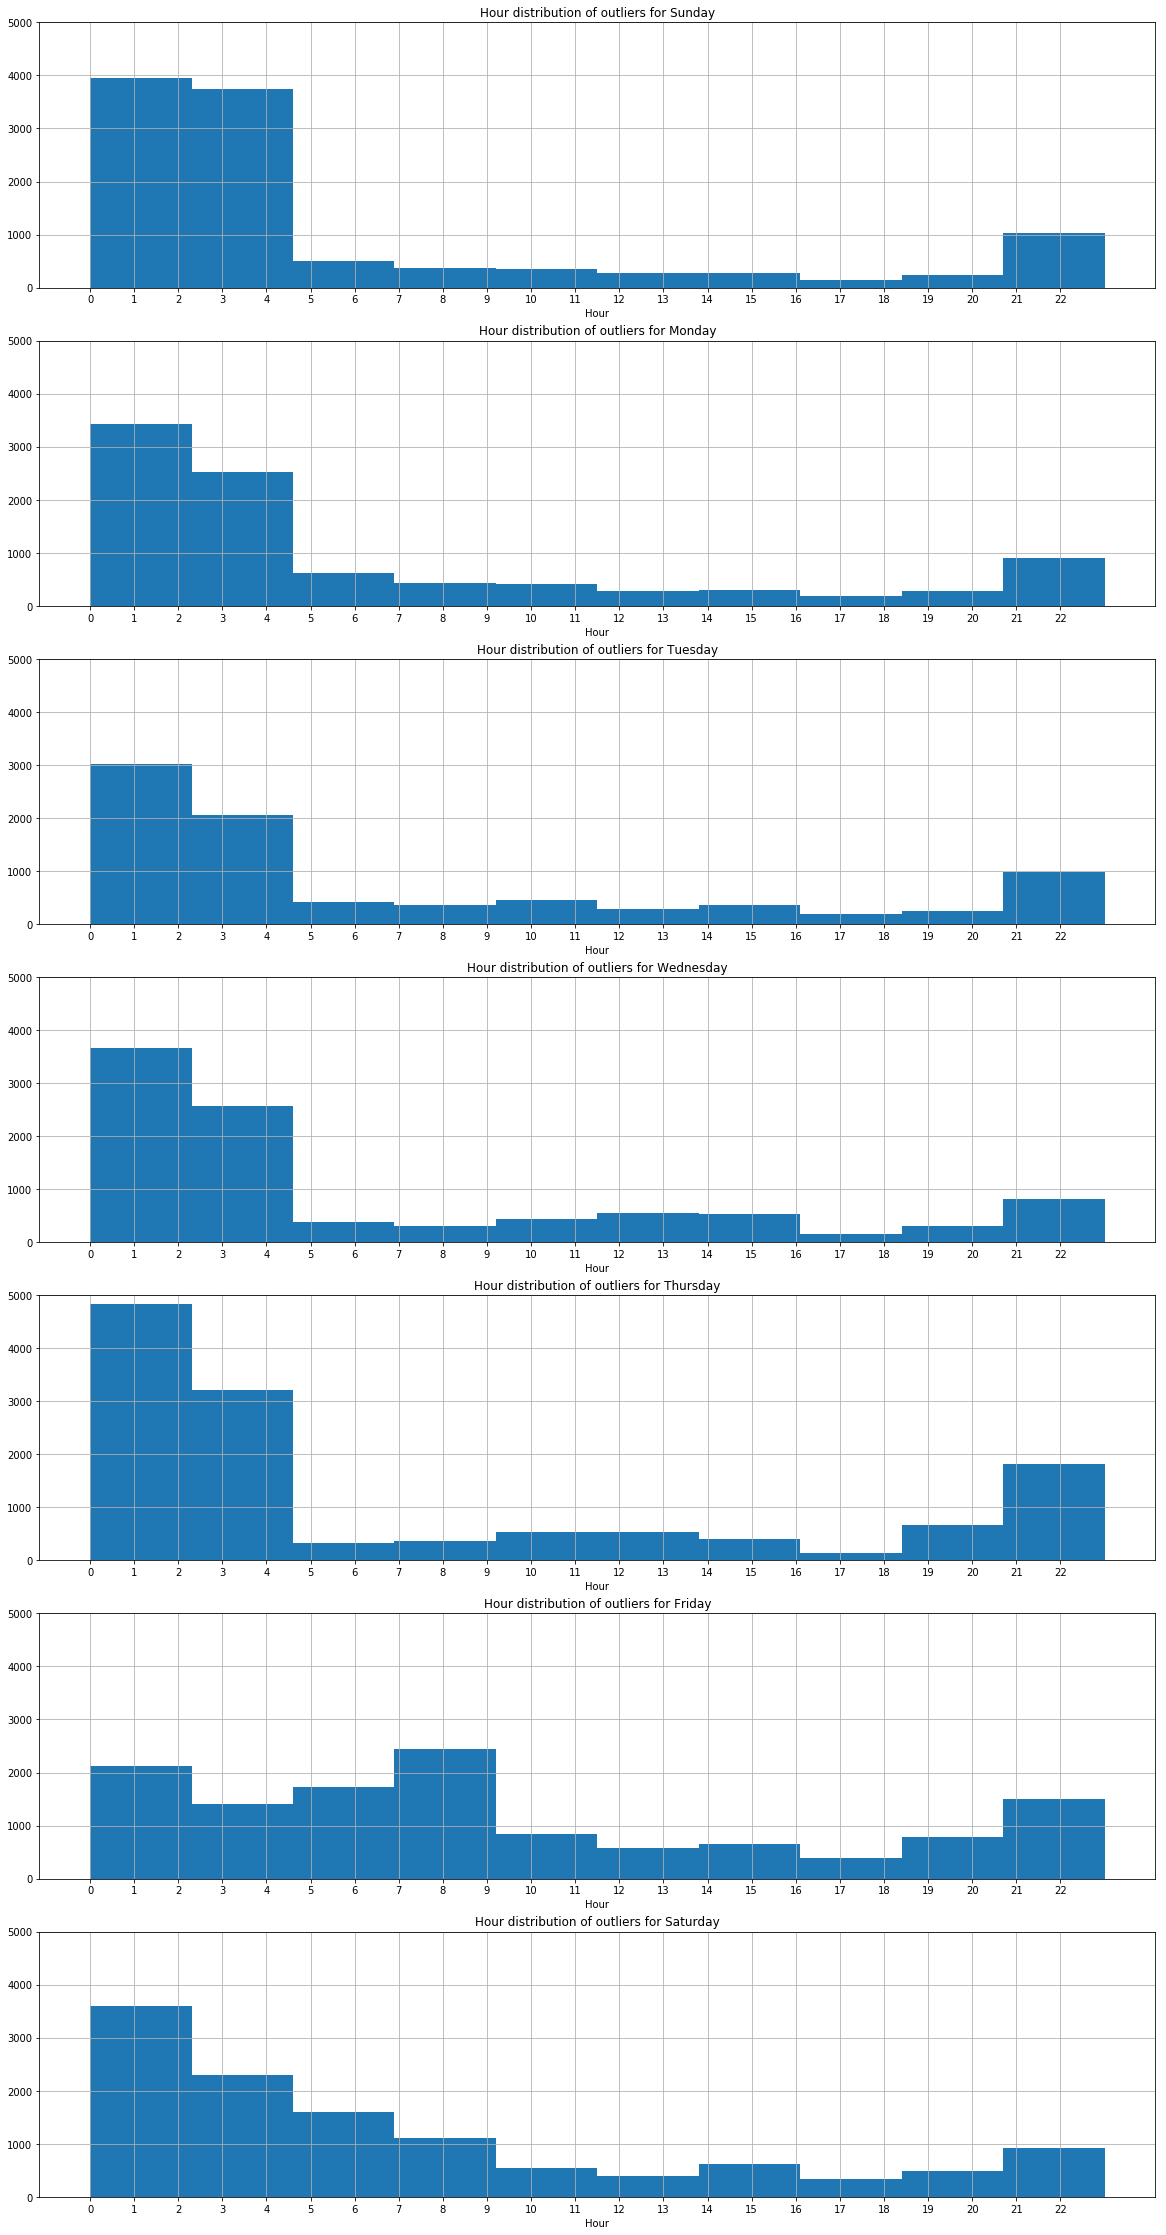

In [53]:
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(20,40))

def get_weekday_name(x):
    if x == 0: 
        return "Sunday"
    if x == 1:
        return "Monday"
    if x == 2:
        return "Tuesday"
    if x == 3:
        return "Wednesday"
    if x == 4:
        return "Thursday"
    if x == 5:
        return "Friday"
    if x == 6:
        return "Saturday"

for day in [0,1,2,3,4,5,6]:
    (outliers['datetime_bin'].loc[outliers['datetime_bin'].dt.dayofweek == day]).dt.hour.hist(ax=ax[day])
    ax[day].set_ylim(0,5000)
    ax[day].set_xticks(np.arange(0, 23, 1))
    ax[day].set_title("Hour distribution of outliers for "+ get_weekday_name(day))
    ax[day].set_xlabel("Hour")

Most outliers appear during the morning rush hour. Look into the outliers that occur at rush hour a bit more, because they may not be "extreme values".

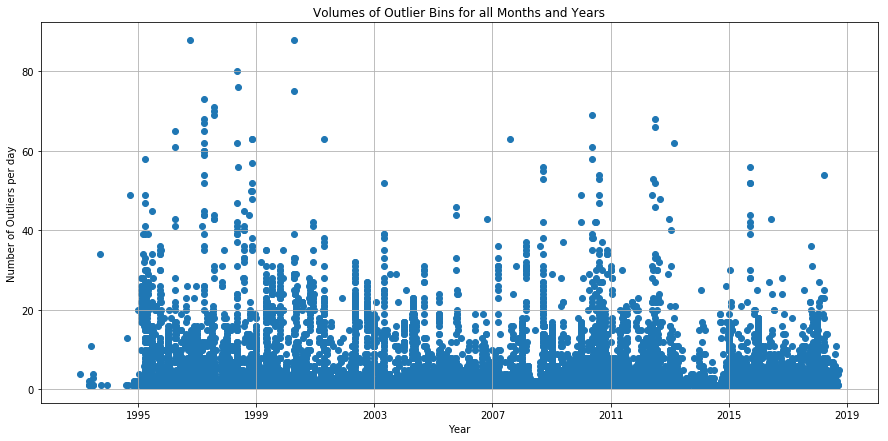

In [116]:
# look at when the outliers occurred and how many outliers occur in a day
fig, ax = plt.subplots(figsize=(15,7))

plt.scatter(x=dts, y=cnts)

ax.set_xlabel("Year")
ax.set_ylabel("Number of Outliers per day")
plt.title("Volumes of Outlier Bins for all Months and Years")
ax.xaxis.grid()
ax.yaxis.grid()

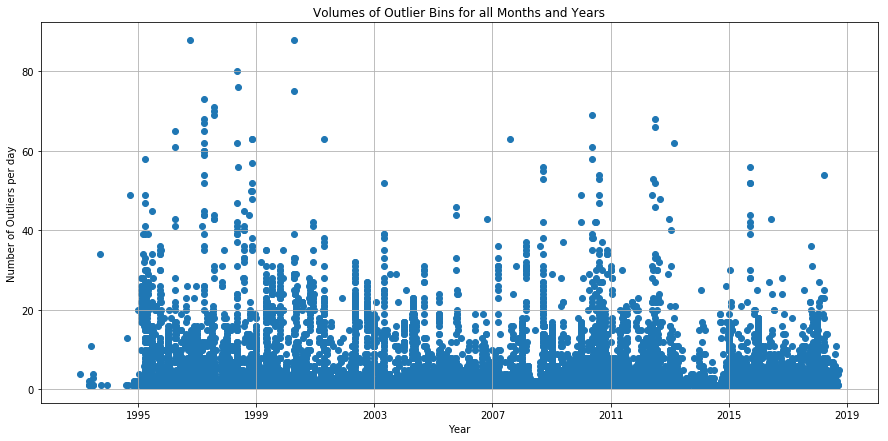

In [117]:
# look at when the outliers occurred and how many outliers occur in a day
fig, ax = plt.subplots(figsize=(15,7))

plt.scatter(x=dts, y=cnts)

ax.set_xlabel("Year")
ax.set_ylabel("Number of Outliers per day")
plt.title("Volumes of Outlier Bins for all Months and Years")
ax.xaxis.grid()
ax.yaxis.grid()

There are a lot of cases with an excessive amount of outliers. 

Look at the class type of the outliers

In [56]:
# the percent of outliers that are vehicles
(len(outliers.loc[outliers['class_type'] =='Vehicles'])/len(outliers))*100

96.66582671317356

In [28]:
# the percent of outliers that are peds
(len(outliers.loc[outliers['class_type'] =='Pedestrians'])/len(outliers))*100

0.0

In [57]:
# the percent of outliers that are bikes
(len(outliers.loc[outliers['class_type'] =='Cyclists'])/len(outliers))*100

3.334173286826435

Look at the total counts of outliers for days that have outliers that occur at rush hour in order to examine if these values are occuring during rush hour or not. 

In [58]:
cnts = []
dts = []
for i in range(0, len(counts.values)):
    cnts.append(counts.values[i][0])
    dts.append(counts.index[i][0])

In [59]:
d = {"counts":cnts, "date":dts} 
dates_counts = pd.DataFrame(data=d, index=dts)

time_date_counts = dates_counts.merge(outliers, on='date')

In [60]:
rush_hour_counts = time_date_counts.loc[(time_date_counts['datetime_bin'].dt.hour.isin([7,8,9,15,16,17]))]

<function matplotlib.pyplot.show>

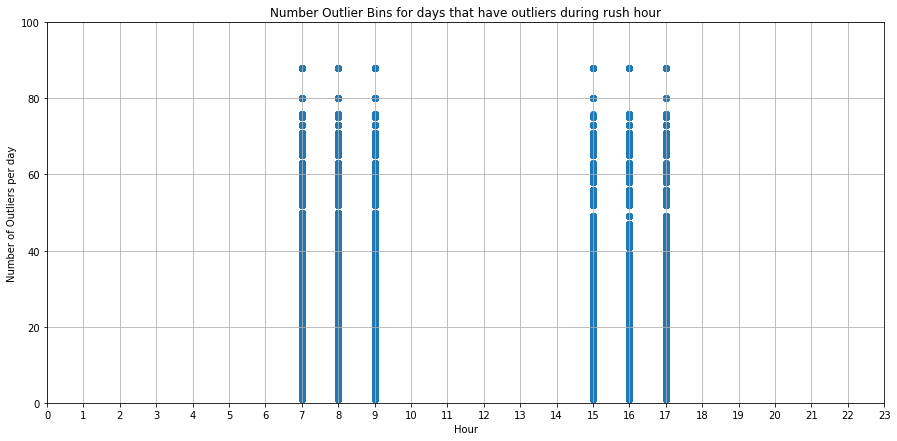

In [69]:
# look at when the outliers occurred and how many outliers occur in a day
fig, ax = plt.subplots(figsize=(15,7))

plt.scatter(x=rush_hour_counts['datetime_bin'].dt.hour, y=rush_hour_counts['counts'])

ax.set_ylim(0, 100)
ax.set_xlabel("Hour")
ax.set_ylabel("Number of Outliers per day")
plt.title("Number Outlier Bins for days that have outliers during rush hour")
ax.xaxis.grid()
ax.yaxis.grid()
plt.xticks(np.arange(0,24,1))
plt.show

A lot of outliers occur on days that rush hour. Try to see if more occur during the weekend or weekdays. 

In [62]:
rush_hour_counts_weekend = rush_hour_counts.loc[rush_hour_counts['weekday_type'] == 'weekend']
rush_hour_counts_weekday = rush_hour_counts.loc[rush_hour_counts['weekday_type'] == 'weekday']

<function matplotlib.pyplot.show>

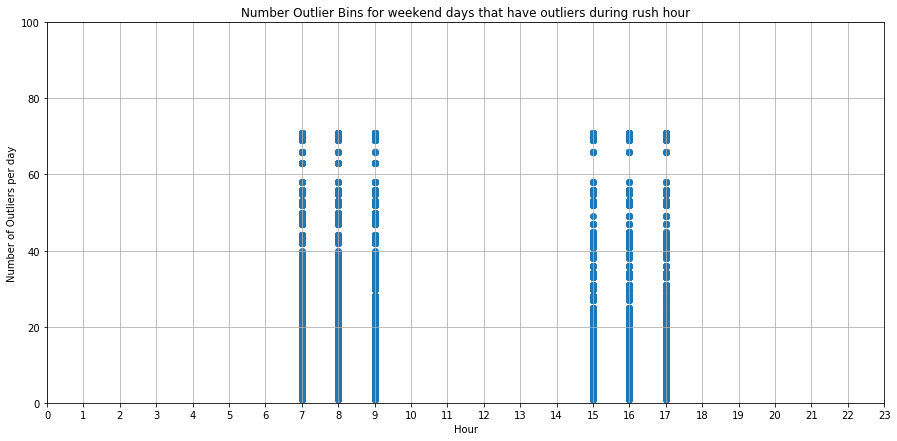

In [68]:
# look at when the outliers occurred and how many outliers occur in a day
fig, ax = plt.subplots(figsize=(15,7))

plt.scatter(x=rush_hour_counts_weekend['datetime_bin'].dt.hour, y=rush_hour_counts_weekend['counts'])

ax.set_ylim(0, 100)
ax.set_xlabel("Hour")
ax.set_ylabel("Number of Outliers per day")
plt.title("Number Outlier Bins for weekend days that have outliers during rush hour")
ax.xaxis.grid()
ax.yaxis.grid()
plt.xticks(np.arange(0,24,1))
plt.show

<function matplotlib.pyplot.show>

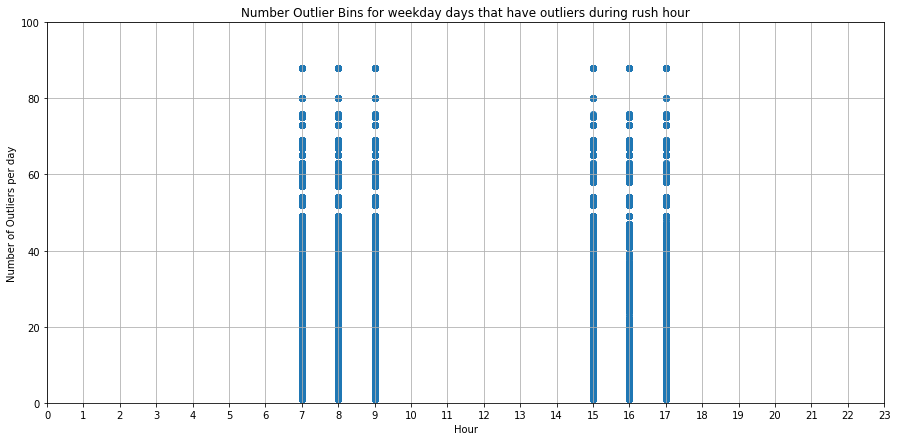

In [70]:
# look at when the outliers occurred and how many outliers occur in a day
fig, ax = plt.subplots(figsize=(15,7))

plt.scatter(x=rush_hour_counts_weekday['datetime_bin'].dt.hour, y=rush_hour_counts_weekday['counts'])

ax.set_ylim(0, 100)
ax.set_xlabel("Hour")
ax.set_ylabel("Number of Outliers per day")
plt.title("Number Outlier Bins for weekday days that have outliers during rush hour")
ax.xaxis.grid()
ax.yaxis.grid()
plt.xticks(np.arange(0,24,1))
plt.show

The above plots show that when a day contains outlier(s) during rush hour, there is never more than 100 outliers for that day at that location for that class type. 

Look at the locations where the outliers occur.

In [28]:
sql = '''
SELECT centreline_id, direction, class_type, COUNT(*) cnt
FROM crosic.atr_permanent_outliers 
WHERE direction IS NOT NULL
GROUP BY centreline_id, direction, class_type
ORDER BY cnt
'''


outlier_location_count = pandasql.read_sql(sql, con)
outlier_location_count

,centreline_id,direction,class_type,cnt
0,11844772,Northbound,Vehicles,1
1,108915,Northbound,Vehicles,1
2,8353520,Eastbound,Cyclists,2
3,445884,Southbound,Vehicles,2
4,913152,Westbound,Vehicles,2
5,10561029,Westbound,Vehicles,2
6,1142672,Westbound,Cyclists,2
7,906966,Eastbound,Vehicles,3
8,11887552,Westbound,Vehicles,3
9,1142672,Eastbound,Cyclists,3


Look at the location (the one with the most outliers), for one week that contains a lot of outliers. The location in question is Lakeshore and Reese in the Westbound direction. 

In [49]:
sql = '''
SELECT * 
FROM crosic.atr_permanent_outliers JOIN open_data.volumes_atr_permanent
USING(centreline_id, direction, class_type, datetime_bin)
WHERE centreline_id = 12763897 and direction = 'Westbound' AND 
date_part('year',datetime_bin) = 1998 AND 
date_part('month', datetime_bin) = 5
AND date_part('day', datetime_bin) IN (9)
'''

may_1998_outliers = pandasql.read_sql(sql, con)

sql = '''
SELECT centreline_id, direction, '1998-05-09'::DATE AS day, date_part('hour', datetime_bin) hr, 
PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY volume_15min)::numeric avg
FROM open_data.volumes_atr_permanent
WHERE centreline_id = 12763897 and direction = 'Westbound' AND 
date_part('month', datetime_bin) = 5 AND date_part('dow', datetime_bin) IN (0,6)
GROUP BY centreline_id, direction, date_part('hour', datetime_bin)
'''

may_1998_avgs = pandasql.read_sql(sql, con)



sql = '''
SELECT centreline_id, direction, '1998-05-09'::DATE AS day, date_part('hour', datetime_bin) hr, 
PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY volume_15min)::numeric avg
FROM open_data.volumes_atr_permanent
WHERE centreline_id = 12763897 and direction = 'Westbound' AND 
date_part('month', datetime_bin) = 5 AND date_part('dow', datetime_bin) IN (0,6)
GROUP BY centreline_id, direction, date_part('hour', datetime_bin)
'''

may_1998_95th = pandasql.read_sql(sql, con)


sql = '''
SELECT centreline_id, direction, '1998-05-09'::DATE AS day, date_part('hour', datetime_bin) hr, 
PERCENTILE_CONT(0.05) WITHIN GROUP (ORDER BY volume_15min)::numeric avg
FROM open_data.volumes_atr_permanent
WHERE centreline_id = 12763897 and direction = 'Westbound' AND 
date_part('month', datetime_bin) = 5 AND date_part('dow', datetime_bin) IN (0,6)
GROUP BY centreline_id, direction,  date_part('hour', datetime_bin)
'''

may_1998_5th = pandasql.read_sql(sql, con)


sql = '''
SELECT centreline_id, direction, datetime_bin, volume_15min
FROM open_data.volumes_atr_permanent
WHERE centreline_id = 12763897 and direction = 'Westbound' AND 
date_part('year',datetime_bin) = 1998 AND 
date_part('month', datetime_bin) = 5 AND date_part('day', datetime_bin) IN (9)
'''

may_1998_raw = pandasql.read_sql(sql, con)

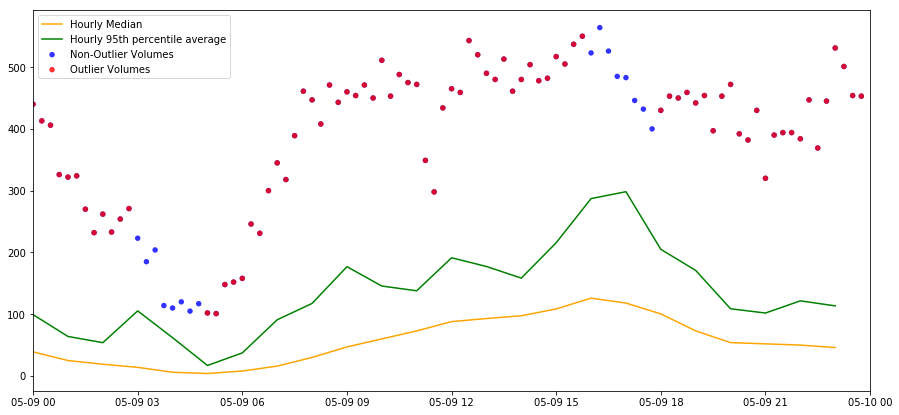

In [50]:
fig, ax = plt.subplots(figsize=(15,7))

# make scatter plot with all values and outliers
data = (may_1998_raw, may_1998_outliers)
colours = ("blue", "red")
groups = ("Non-Outlier Volumes", "Outlier Volumes")

for data, colour, group in zip(data, colours, groups):
    plt.scatter([pd.to_datetime(d) for d in data['datetime_bin']], 
               data['volume_15min'], alpha=0.8, c=colour, edgecolors='none', s=30, label=group)

# make hourly avg line
days = list(may_1998_avgs['day'])

int_hrs = [int(d) for d in may_1998_avgs['hr']]
times =  list(map(datetime.time, int_hrs)) #datetime.time[int(d) for d in may_1998_avgs['hr']]

hourly_avg = pd.DataFrame({'date_hour':list(map(datetime.datetime.combine, days, times)), 'avg':list(may_1998_avgs['avg'])})

plt.plot(hourly_avg['date_hour'], hourly_avg['avg'], label='Hourly Median',  color='orange')


# 95th percentile
days = list(may_1998_95th['day'])

int_hrs = [int(d) for d in may_1998_95th['hr']]
times =  list(map(datetime.time, int_hrs)) #datetime.time[int(d) for d in may_1998_avgs['hr']]

hourly_avg = pd.DataFrame({'date_hour':list(map(datetime.datetime.combine, days, times)), 'avg':list(may_1998_95th['avg'])})

plt.plot(hourly_avg['date_hour'], hourly_avg['avg'], label='Hourly 95th percentile average',  color='green')

'''

# 5th percentile
days = list(may_1998_5th['day'])

int_hrs = [int(d) for d in may_1998_5th['hr']]
times =  list(map(datetime.time, int_hrs)) #datetime.time[int(d) for d in may_1998_avgs['hr']]

hourly_avg = pd.DataFrame({'date_hour':list(map(datetime.datetime.combine, days, times)), 'avg':list(may_1998_5th['avg'])})

plt.plot(hourly_avg['date_hour'], hourly_avg['avg'], label='Hourly 5th percentile average',  color='purple')

'''

ax.set_xlim(datetime.date(1998, 5, 9), datetime.date(1998, 5, 10))
plt.legend(loc=2)
plt.show()

In [337]:
# look to see if other locations have a lot of outliers on the 9th and 10th 
sql = '''

SELECT DISTINCT centreline_id, location, direction, date_part('day', datetime_bin) AS day, COUNT(*) AS num_outliers
FROM crosic.atr_permanent_outliers JOIN open_data.volumes_atr_permanent
USING (centreline_id, direction, datetime_bin)
WHERE date_part('year',datetime_bin) = 1998 AND 
date_part('month', datetime_bin) = 5 AND date_part('day', datetime_bin) IN (9, 10)
GROUP BY direction, centreline_id, date_part('day', datetime_bin), location
ORDER BY centreline_id, direction, day
'''
pandasql.read_sql(sql, con)

,centreline_id,location,direction,day,num_outliers
0,908543,DIXON RD W/B E OF ISLINGTON AVE,Westbound,9.0,1
1,908543,DIXON RD W/B E OF ISLINGTON AVE,Westbound,10.0,1
2,908544,ISLINGTON AVE S/B N OF DIXON RD,Southbound,9.0,1
3,908544,ISLINGTON AVE S/B N OF DIXON RD,Southbound,10.0,1
4,908664,ISLINGTON AVE N/B S OF DIXON RD,Northbound,9.0,1
5,908664,ISLINGTON AVE N/B S OF DIXON RD,Northbound,10.0,1
6,1145202,LAKE SHORE BLVD E/B W OF DON RDWY,Eastbound,9.0,39
7,1145202,LAKE SHORE BLVD E/B W OF DON RDWY,Eastbound,10.0,12
8,1145202,LAKE SHORE BLVD W/B W OF DON RDWY,Westbound,9.0,10
9,1147026,LAKE SHORE BLVD E/B W OF REES ST,Eastbound,9.0,3


It seems that other locations seem to have a lot of outliers on these two days. Upon further investigation, the 8th is a Friday and the 10th is Mother's Day so perhaps the holiday caused an increase in Vehicle traffic. Also, a lot of the outlier values are occuring on Lake Shore Blvd on these days, perhaps there was something that happened on Lake Shore these days to cause a greater amount of traffic. 

In [37]:
sql = '''
SELECT * 
FROM crosic.atr_permanent_outliers JOIN open_data.volumes_atr_permanent
USING(centreline_id, direction, class_type, datetime_bin)
WHERE centreline_id = 12763897 and direction = 'Westbound' AND 
date_part('year',datetime_bin) = 2007 AND 
date_part('month', datetime_bin) = 3
'''

mar2007_outliers = pandasql.read_sql(sql, con)

sql = '''
SELECT centreline_id, direction, class_type, date_part('hour', datetime_bin) hr, '2007-03-06'::DATE AS day,
(PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY volume_15min)::numeric) avg
FROM open_data.volumes_atr_permanent
WHERE centreline_id = 12763897 and direction = 'Westbound' AND 
date_part('month', datetime_bin) = 3 AND date_part('dow', datetime_bin) IN (1,2,3,4,5)
AND class_type = 'Vehicles'
GROUP BY centreline_id, direction, class_type,  date_part('hour', datetime_bin)
'''

mar2007_avgs = pandasql.read_sql(sql, con)


sql = '''
SELECT centreline_id, direction, class_type, date_part('hour', datetime_bin) hr, '2007-03-06'::DATE AS day,
(PERCENTILE_CONT(0.95) WITHIN GROUP (ORDER BY volume_15min)::numeric) avg
FROM open_data.volumes_atr_permanent
WHERE centreline_id = 12763897 and direction = 'Westbound' AND 
date_part('month', datetime_bin) = 3 AND date_part('dow', datetime_bin) IN (1,2,3,4,5)
AND class_type = 'Vehicles'
GROUP BY centreline_id, direction, class_type,  date_part('hour', datetime_bin)
'''

mar2007_95th = pandasql.read_sql(sql, con)



sql = '''
SELECT centreline_id, direction, class_type,  date_part('hour', datetime_bin) hr, '2007-03-06'::DATE AS day,
(PERCENTILE_CONT(0.05) WITHIN GROUP (ORDER BY volume_15min)::numeric) avg
FROM open_data.volumes_atr_permanent
WHERE centreline_id = 12763897 and direction = 'Westbound' AND 
date_part('month', datetime_bin) = 3 AND date_part('dow', datetime_bin) IN (1,2,3,4,5)
AND class_type = 'Vehicles'
GROUP BY centreline_id, direction, class_type, date_part('hour', datetime_bin)
'''

mar2007_5th = pandasql.read_sql(sql, con)



sql = '''
SELECT centreline_id, direction, datetime_bin, class_type, volume_15min
FROM open_data.volumes_atr_permanent
WHERE centreline_id = 12763897 and direction = 'Westbound' AND 
date_part('year',datetime_bin) = 2007 AND 
date_part('month', datetime_bin) = 3 AND date_part('day', datetime_bin) IN (6)
'''

mar2007_raw = pandasql.read_sql(sql, con)

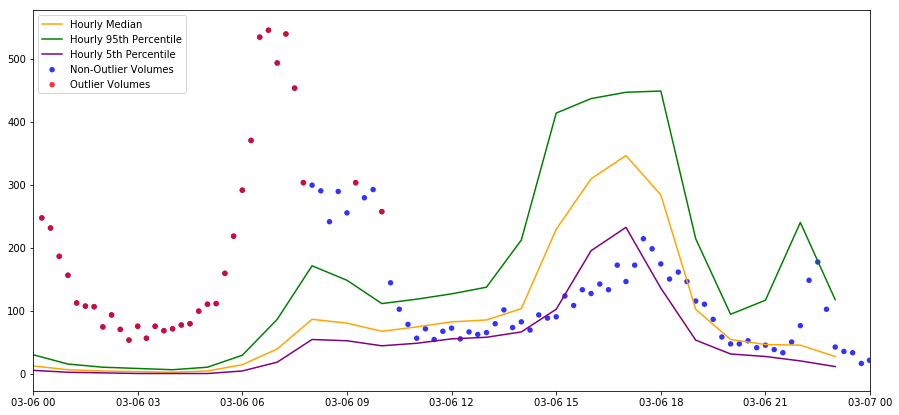

In [38]:
fig, ax = plt.subplots(figsize=(15,7))

# make scatter plot with all values and outliers
data = (mar2007_raw, mar2007_outliers)
colours = ("blue", "red")
groups = ("Non-Outlier Volumes", "Outlier Volumes")

for data, colour, group in zip(data, colours, groups):
    plt.scatter([pd.to_datetime(d) for d in data['datetime_bin']], 
               data['volume_15min'], alpha=0.8, c=colour, edgecolors='none', s=30, label=group)

# make hourly avg line
days = list(mar2007_avgs['day'])

int_hrs = [int(d) for d in mar2007_avgs['hr']]
times =  list(map(datetime.time, int_hrs)) #datetime.time[int(d) for d in may_1998_avgs['hr']]

hourly_avg = pd.DataFrame({'date_hour':list(map(datetime.datetime.combine, days, times)), 'avg':list(mar2007_avgs['avg'])})

plt.plot(hourly_avg['date_hour'], hourly_avg['avg'], label='Hourly Median',  color='orange')


# make hourly 95th percentile line
days = list(mar2007_95th['day'])

int_hrs = [int(d) for d in mar2007_95th['hr']]
times =  list(map(datetime.time, int_hrs)) #datetime.time[int(d) for d in may_1998_avgs['hr']]

hourly_avg = pd.DataFrame({'date_hour':list(map(datetime.datetime.combine, days, times)), 'avg':list(mar2007_95th['avg'])})

plt.plot(hourly_avg['date_hour'], hourly_avg['avg'], label='Hourly 95th Percentile',  color='green')

# 5th 
days = list(mar2007_5th['day'])

int_hrs = [int(d) for d in mar2007_5th['hr']]
times =  list(map(datetime.time, int_hrs)) #datetime.time[int(d) for d in may_1998_avgs['hr']]

hourly_avg = pd.DataFrame({'date_hour':list(map(datetime.datetime.combine, days, times)), 'avg':list(mar2007_5th['avg'])})

plt.plot(hourly_avg['date_hour'], hourly_avg['avg'], label='Hourly 5th Percentile',  color='purple')


ax.set_xlim(datetime.date(2007, 3, 6), datetime.date(2007, 3, 7))
plt.legend(loc=2)
plt.show()

In [343]:
sql = '''
SELECT DISTINCT centreline_id, direction, location, class_type, date_part('day', datetime_bin) AS day, 
COUNT(*) AS num_outliers 
FROM crosic.atr_permanent_outliers JOIN open_data.volumes_atr_permanent
USING (centreline_id, direction, datetime_bin, class_type)
WHERE date_part('year',datetime_bin) = 2007 AND 
date_part('month', datetime_bin) = 3 AND date_part('day', datetime_bin) = 6
GROUP BY direction, centreline_id, class_type, date_part('day', datetime_bin), location
ORDER BY centreline_id, direction, day
'''
pandasql.read_sql(sql, con)

,centreline_id,direction,location,class_type,day,num_outliers
0,1145202,Eastbound,LAKE SHORE BLVD E/B W OF DON RDWY,Vehicles,6.0,10
1,1145202,Westbound,LAKE SHORE BLVD W/B W OF DON RDWY,Vehicles,6.0,2
2,1145945,Eastbound,LAKE SHORE BLVD E/B W OF SMALL ST,Vehicles,6.0,2
3,1146181,Eastbound,LAKE SHORE BLVD E/B W OF SHERBOURNE ST,Vehicles,6.0,2
4,1146358,Westbound,LAKE SHORE BLVD W/B E OF FREELAND ST,Vehicles,6.0,26
5,1146615,Westbound,LAKE SHORE BLVD W/B W OF BAY ST,Vehicles,6.0,6
6,1147026,Eastbound,LAKE SHORE BLVD E/B W OF REES ST,Vehicles,6.0,2
7,1147135,Westbound,LAKE SHORE BLVD W/B E OF COLBORNE LODGE DR,Vehicles,6.0,28
8,1147201,Eastbound,LAKE SHORE BLVD E/B W OF BATHURST ST,Vehicles,6.0,1
9,1147201,Westbound,LAKE SHORE BLVD W/B E OF STADIUM RD,Vehicles,6.0,31


It seems that a lot of areas of Lake Shore Blvd also have a lot of outliers on this day. This causes me to believe that there potentially could be something happening on Lake Shore and that these are not extreme values. I looked at the outliers from `centreline_id 10250082`, and the outliers at this location also occurs during the early hours of the morning, and are similar volumes. 

# Classify Extreme Values

To classify dates and locations with extreme values, I will only look at locations with more than 5 outliers over the course of the day. Also, if there are other streets in the city with a lot of outliers that day, then I will not include those in the final excetptions view. 

I used queries such as these to look into which values/days will be removed with different parameters.
```sql 
WITH greater_5 AS (
SELECT centreline_id, direction, class_type, datetime_bin::DATE AS dt, COUNT(*) cnt
FROM crosic.atr_permanent_outliers
WHERE centreline_id IS NOT NULL
GROUP BY centreline_id, direction, class_type, datetime_bin::DATE
HAVING COUNT(*) > 5

)

SELECT SUM(num_locations_with_at_least_5_outliers_this_day) FROM 
(
SELECT dt, COUNT(*) AS num_locations_with_at_least_5_outliers_this_day 
FROM greater_5 
GROUP BY dt
HAVING COUNT(*) < 2
) c



WITH greater_10 AS (
SELECT centreline_id, direction, class_type, datetime_bin::DATE AS dt, COUNT(*) cnt
FROM crosic.atr_permanent_outliers
WHERE centreline_id IS NOT NULL
GROUP BY centreline_id, direction, class_type, datetime_bin::DATE
HAVING COUNT(*) > 10
ORDER BY num_locations_with_at_least_10_outliers_this_day 
)


SELECT dt, COUNT(*) AS num_locations_with_at_least_10_outliers_this_day 
FROM greater_10
GROUP BY dt
HAVING COUNT(*) <= 5
ORDER BY num_locations_with_at_least_10_outliers_this_day 
```

In the end I decided to remove date-location-class combinations with more than 5 outliers in a day, and 3 or fewer other date-location-class combinations with more than 5 outliers in day. 

The final view:
```sql 
CREATE MATERIALIZED VIEW open_data.volumes_atr_permanent_exceptions_2 AS 
(   

SELECT DISTINCT greater_5.direction, greater_5.centreline_id, greater_5.class_type, greater_5.dt, location
FROM
(
SELECT dt, COUNT(*) AS num_locations_with_at_least_5_outliers_this_day 
FROM (
	SELECT centreline_id, direction, class_type, datetime_bin::DATE AS dt, COUNT(*) cnt
	FROM crosic.atr_permanent_outliers
	WHERE centreline_id IS NOT NULL
	GROUP BY centreline_id, direction, class_type, datetime_bin::DATE
	HAVING COUNT(*) > 5
) greater_than_5

GROUP BY dt
HAVING COUNT(*) <= 3
ORDER BY num_locations_with_at_least_5_outliers_this_day 
) AS dates
JOIN (
	SELECT centreline_id, direction, class_type, datetime_bin::DATE AS dt, COUNT(*) cnt
	FROM crosic.atr_permanent_outliers
	WHERE centreline_id IS NOT NULL
	GROUP BY centreline_id, direction, class_type, datetime_bin::DATE
	HAVING COUNT(*) > 5
) greater_5
ON dates.dt = greater_5.dt
JOIN open_data.volumes_atr_permanent p
ON greater_5.dt = p.datetime_bin::DATE AND greater_5.centreline_id = p.centreline_id
AND greater_5.direction = p.direction AND greater_5.class_type = p.class_type
ORDER BY dt
)
```

In [15]:
con.close()